In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from censai import PhysicalModelv2, RIMSourceUnetv2, PowerSpectrum
from censai.models import UnetModelv2, RayTracer
from censai.utils import nullwriter, rim_residual_plot as residual_plot, plot_to_image
from censai.data.lenses_tng_v3 import decode_train, decode_physical_model_info
from censai.definitions import DTYPE
import os, glob, re, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from argparse import Namespace
import math, json
import matplotlib.pylab as pylab
import h5py
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 200)

result_dir = os.path.join(os.getenv("CENSAI_PATH"), "results")
data_path = os.path.join(os.getenv("CENSAI_PATH"), "data")
models_path = os.path.join(os.getenv("CENSAI_PATH"), "models")

params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [ ]:
model = "RIMSource128hstv3_control_002_A0_L3_FLM1.0_211108220845"

checkpoints_dir = os.path.join(os.getenv("CENSAI_PATH"), "models", model)
with open(os.path.join(checkpoints_dir, "script_params.json"), "r") as f:
    args = json.load(f)
args = Namespace(**args)
_dataset = os.path.split(args.val_datasets[0])[-1]


files = glob.glob(os.path.join(os.getenv("CENSAI_PATH"), "data", _dataset, "*.tfrecords"))
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"),
                           block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
for physical_params in dataset.map(decode_physical_model_info):
    break
dataset = dataset.map(decode_train)

total_items = int(np.loadtxt(os.path.join(os.getenv("CENSAI_PATH"), "data", _dataset, "dataset_size.txt")))
print(total_items)

In [ ]:
phys = PhysicalModelv2(
    pixels=physical_params["pixels"].numpy(),
    kappa_pixels=physical_params["kappa pixels"].numpy(),
    src_pixels=physical_params["src pixels"].numpy(),
    image_fov=physical_params["image fov"].numpy(),
    kappa_fov=physical_params["kappa fov"].numpy(),
    src_fov=physical_params["source fov"].numpy(),
    method="fft"
)

unet = UnetModelv2(
    filters=args.filters,
    filter_scaling=args.filter_scaling,
    kernel_size=args.kernel_size,
    layers=args.layers,
    block_conv_layers=args.block_conv_layers,
    strides=args.strides,
    bottleneck_kernel_size=args.bottleneck_kernel_size,
    resampling_kernel_size=args.resampling_kernel_size,
    input_kernel_size=args.input_kernel_size,
    gru_kernel_size=args.gru_kernel_size,
    upsampling_interpolation=args.upsampling_interpolation,
    kernel_l2_amp=args.kernel_l2_amp,
    bias_l2_amp=args.bias_l2_amp,
    kernel_l1_amp=args.kernel_l1_amp,
    bias_l1_amp=args.bias_l1_amp,
    activation=args.activation,
    initializer=args.initializer,
    batch_norm=args.batch_norm,
    dropout_rate=args.dropout_rate
)
rim = RIMSourceUnetv2(
    physical_model=phys,
    unet=unet,
    steps=args.steps,
    adam=args.adam,
    source_link=args.source_link,
    source_init=args.source_init,
    flux_lagrange_multiplier=args.flux_lagrange_multiplier
)
ckpt = tf.train.Checkpoint(net=rim.unet)
checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

In [ ]:
for lens, source, kappa, noise_rms, psf in dataset.skip(0).batch(1):
    break

In [ ]:
# overwrite call since we don't want to update the source in the call function
def unet_call(self, xt, states, grad):
    delta_xt = tf.concat([tf.identity(xt), grad], axis=3)
    delta_xt = self.input_layer(delta_xt)
    skip_connections = []
    new_states = []
    for i in range(self._num_layers):
        c_i, delta_xt = self.encoding_layers[i](delta_xt)
        c_i, new_state = self.gated_recurrent_blocks[i](c_i, states[i])  # Pass skip connections through GRU and update states
        skip_connections.append(c_i)
        new_states.append(new_state)
    skip_connections = skip_connections[::-1]
    delta_xt = self.bottleneck_layer1(delta_xt)
    delta_xt = self.bottleneck_layer2(delta_xt)
    delta_xt, new_state = self.bottleneck_gru(delta_xt, states[-1])
    new_states.append(new_state)
    for i in range(self._num_layers):
        delta_xt = self.decoding_layers[i](delta_xt, skip_connections[i])
    delta_xt = self.output_layer(delta_xt)
    return delta_xt, new_states

In [ ]:
epsilon = lambda step: 1/(step) if step > 8 else 1.
noise = lambda source, step: tf.random.normal(stddev=epsilon(step), shape=source.shape)

In [119]:
steps = 300
batch_size = lens.shape[0]
source_pred, states = rim.initial_states(batch_size)
source_series = tf.TensorArray(DTYPE, size=steps)
chi_squared_series = tf.TensorArray(DTYPE, size=steps)
for current_step in tqdm(range(steps)):
    with tf.GradientTape() as g:
        g.watch(source_pred)
        y_pred = rim.physical_model.forward(rim.source_link(source_pred), kappa, psf)
        flux_term = tf.square(tf.reduce_sum(y_pred, axis=(1, 2, 3)) - tf.reduce_sum(lens, axis=(1, 2, 3)))
        log_likelihood = 0.5 * tf.reduce_sum(tf.square(y_pred - lens) / noise_rms[:, None, None, None]**2, axis=(1, 2, 3))
        cost = tf.reduce_mean(log_likelihood + rim.flux_lagrange_multiplier * flux_term)
    grad = g.gradient(cost, source_pred)
    grad = rim.grad_update(grad, current_step)
    projected_noise, _ = unet_call(unet, xt=noise(source, current_step), grad=grad, states=states)
    delta_source_pred, states = unet_call(unet, xt=source_pred, grad=grad, states=states)
    source_pred =  source_pred + epsilon(current_step)/2 * delta_source_pred + projected_noise
#     source_pred =  source_pred + epsilon(current_step)/2 * delta_source_pred
    source_series = source_series.write(index=current_step, value=source_pred)
    if current_step > 0:
        chi_squared_series = chi_squared_series.write(index=current_step-1, value=log_likelihood)
# last step score
log_likelihood = rim.physical_model.log_likelihood(y_true=lens, source=rim.source_link(source_pred), kappa=kappa, psf=psf, noise_rms=noise_rms)
chi_squared_series = chi_squared_series.write(index=steps-1, value=log_likelihood)
source_pred = source_series.stack()
chi_squared = chi_squared_series.stack()

100%|██████████| 20/20 [00:00<00:00, 45.06it/s]


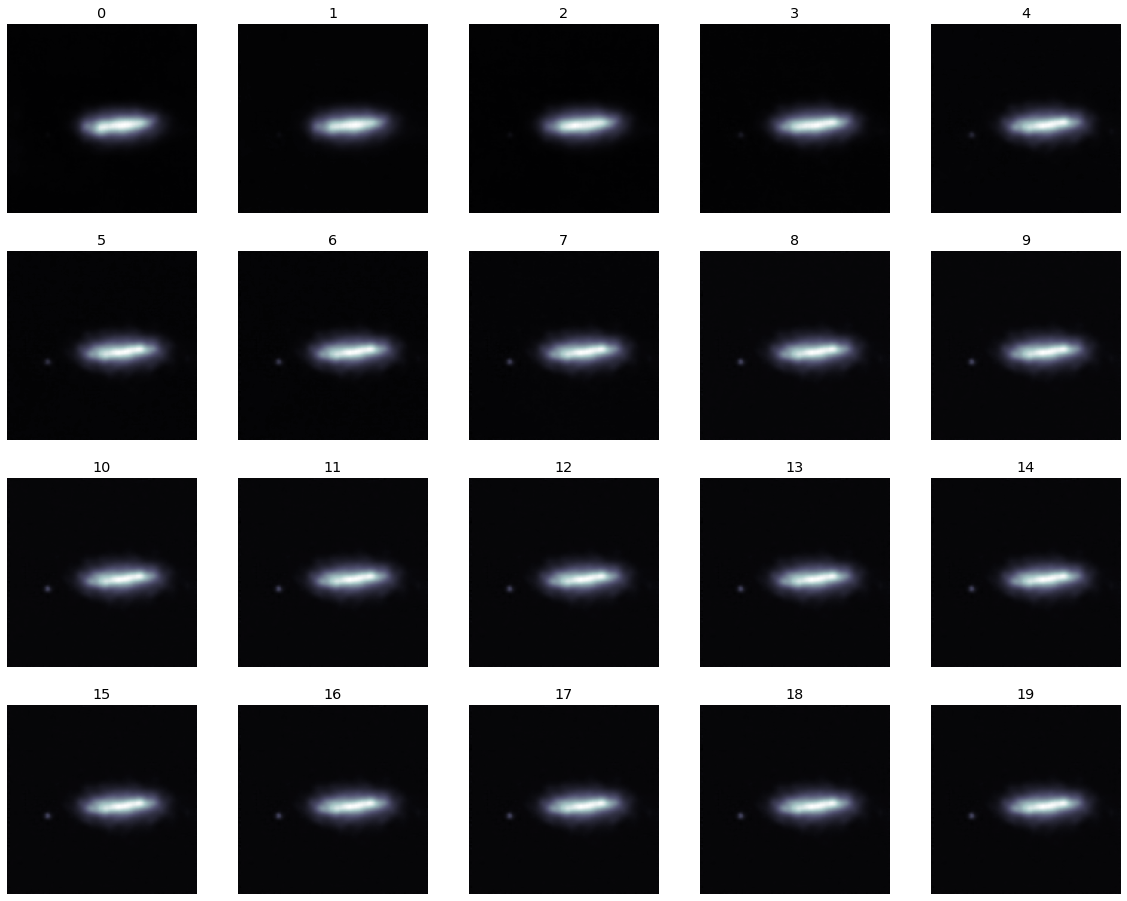

In [120]:
fig, axs = plt.subplots(4, 5, figsize=(20, 16))

for i in range(4):
    for j in range(5):
        k = j + 5 * i
        axs[i, j].imshow(source_pred[k, 0, ..., 0], cmap="bone")
        axs[i, j].set_title(f"{k}")
        axs[i, j].axis("off")

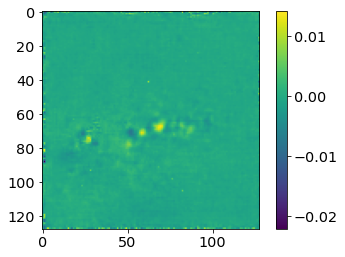

In [121]:
plt.imshow(delta_source_pred[0, ..., 0])
plt.colorbar()

In [ ]:
fig, axs = plt.subplots(9, 9, figsize=(45, 45))

for i in range(9):
    for j in range(9):
        k = j + 9 * i + 0
        axs[i, j].imshow(source_pred[k, 0, ..., 0], cmap="bone")
        axs[i, j].axis("off")